
```bash
python3 run.py --parallel true --device cuda --epoch 100 --batch-size 128
```

| None | 1e-7 | 50.0 | 75.0 | 100.0 |
| :--- | :----: | :----: | :-----: | :-----: |
| ODENet | 0.996$\pm$0.001| 0.959$\pm$0.024 | 0.901$\pm$0.058 | 0.791$\pm$0.107 | 0.628$\pm$0.139 |
| CNN | 0.998$\pm$0.002| 0.612$\pm$0.203 | 0.45$\pm$0.165 | 0.351$\pm$0.115 | 0.283$\pm$0.078 |

In [4]:
# Necessary
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torchdiffeq import odeint_adjoint as odeint
from jupyterthemes import jtplot
from utils import *
import json
import pandas as pd
from pandas import  json_normalize 
jtplot.style(theme="chesterish")
 # CONSTANT 
device = "cuda"
EPOCHS=1
BATCH_SIZE=32
IMG_SIZE=(32,32,3)

ModuleNotFoundError: No module named 'torch'

In [2]:
result = json.loads(open("result/evaluate.json", "r").readline())
ode_result = pd.DataFrame.from_dict(result["ode"]) 
cnn_result = pd.DataFrame.from_dict(result["cnn"])


In [3]:
ode_result.mean()

null     0.996217
1e-07    0.958917
50.0     0.901047
75.0     0.790557
100.0    0.627840
dtype: float64

In [4]:
def table_(result_):
    means = []
    stds = []
    for column in result_:
#        print(str(column))
#        result_[column].astype('float64')
#        print(result_[column].describe())
#        print("\n\n")
        des = result_[column].describe()
       # print(des["mean"])
        means.append(des["mean"])
        stds.append(des["std"])
    return means,stds
ode_means, ode_std = table_(ode_result)
cnn_means, cnn_std = table_(cnn_result)

In [5]:
with open("result/mnist.md", "w") as f:
    f.write("| None | 1e-7 | 50.0 | 75.0 | 100.0 |\n")
    f.write("| :--- | :----: | :----: | :-----: | :-----: |\n")
    f.write(f"| ODENet | {round(ode_means[0],3)}$\pm${round(ode_std[0],3)}| {round(ode_means[1],3)}$\pm${round(ode_std[1],3)} | {round(ode_means[2],3)}$\pm${round(ode_std[2],3)} | {round(ode_means[3],3)}$\pm${round(ode_std[3],3)} | {round(ode_means[4],3)}$\pm${round(ode_std[4],3)} |\n")
    f.write(f"| CNN | {round(cnn_means[0],3)}$\pm${round(cnn_std[0],3)}| {round(cnn_means[1],3)}$\pm${round(cnn_std[1],3)} | {round(cnn_means[2],3)}$\pm${round(cnn_std[2],3)} | {round(cnn_means[3],3)}$\pm${round(cnn_std[3],3)} | {round(cnn_means[4],3)}$\pm${round(cnn_std[4],3)} |")

In [41]:
def convert_lines_to_dict(path):
    s = open(path, "r").readlines()
    lines = []
    for S in s:
        S = S.replace("\n","").replace("'","").strip()
        lines.append(S)
    lines = "".join(lines)
    d = json.loads(lines)
    return d

In [47]:
ode = convert_lines_to_dict("result/ode_results/mnist_origin.json")
cnn = convert_lines_to_dict("result/cnn_results/mnist_origin.json")
ode

{'loss': [84.36157435178757,
  81.25533485412598,
  79.08083266019821,
  78.25081622600555,
  78.03670114278793,
  77.30910962820053,
  77.1155007481575,
  77.05209678411484,
  76.98829537630081,
  76.97366112470627,
  76.9071329832077,
  76.93898183107376,
  76.87578004598618,
  76.88533437252045,
  76.8956732749939,
  76.85464465618134,
  76.85306453704834,
  76.83815628290176,
  76.81315737962723,
  76.84018760919571,
  76.81418371200562,
  76.82071226835251,
  76.78486251831055,
  76.81747037172318,
  76.79852122068405,
  76.7936178445816,
  76.78311175107956,
  76.77321135997772,
  76.81008952856064,
  76.78020745515823,
  76.76726025342941,
  76.77519232034683,
  76.78384101390839,
  76.76936906576157,
  76.75568574666977,
  76.76045286655426,
  76.80219447612762,
  76.74871569871902,
  76.7505054473877,
  76.7648497223854,
  76.76101362705231,
  76.75169116258621,
  76.75041788816452,
  76.73538476228714,
  76.73223692178726,
  76.7646894454956,
  76.74557483196259,
  76.7509488

/tmp/ipykernel_61967/123457297.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  loss_fig.show()


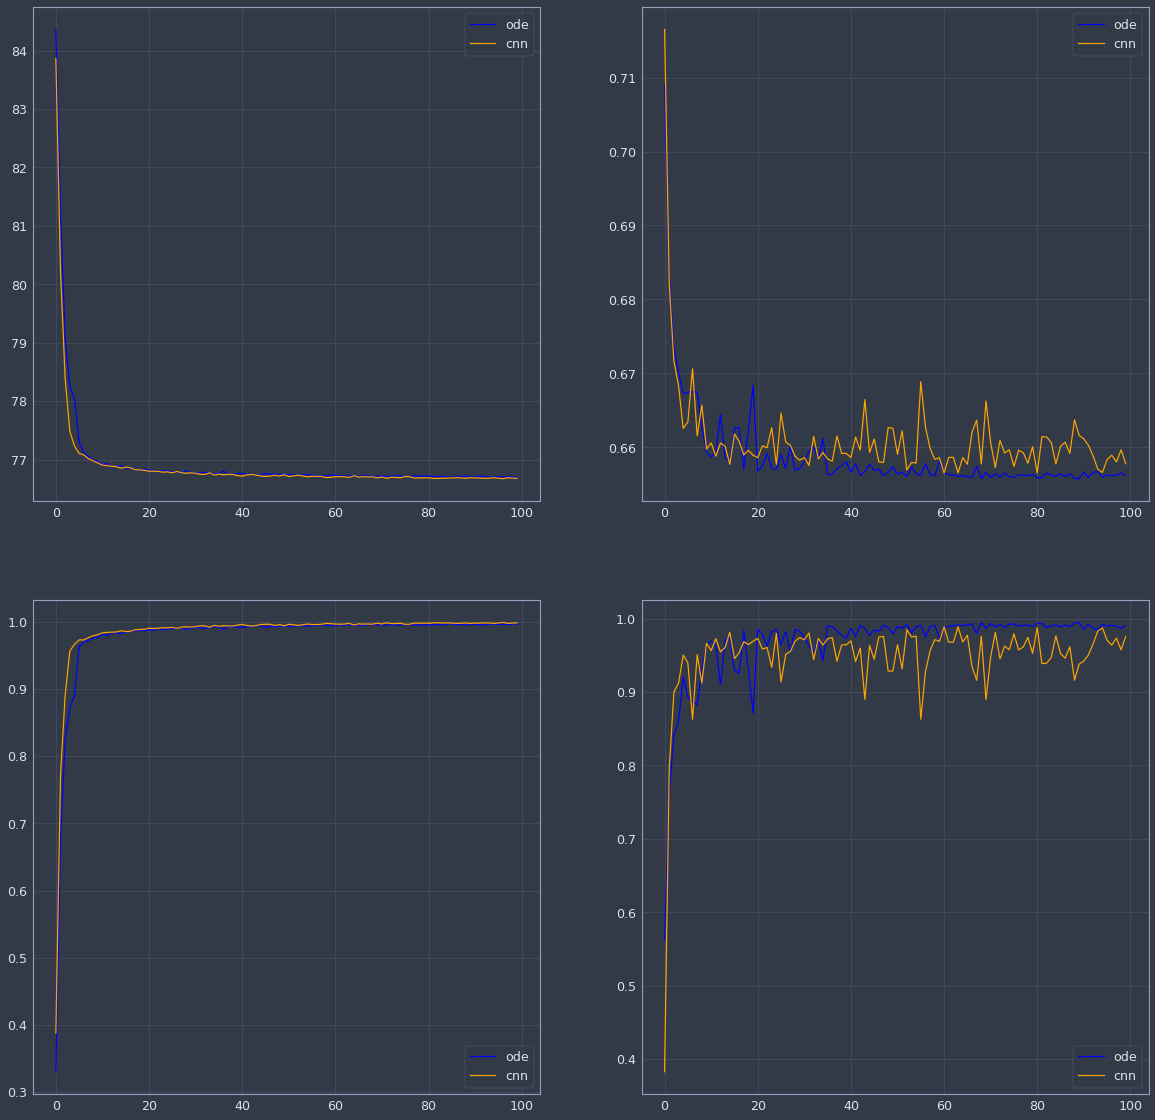

In [54]:
def comparision(ode, cnn):
    x_ = len(ode["loss"])
    x_ = [i for i in range(x_)]
    loss_fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
    ax[0][0].plot(x_, ode["loss"], color="blue", label="ode")
    ax[0][0].plot(x_, cnn["loss"], color="orange", label="cnn")
    ax[0][0].legend() 
    ax[0][1].plot(x_, ode["val_loss"], color="blue", label="ode")
    ax[0][1].plot(x_, cnn["val_loss"], color="orange",label = "cnn")
    ax[0][1].legend() 
    ax[1][0].plot(x_, ode["acc"], color="blue", label="ode")
    ax[1][0].plot(x_, cnn["acc"], color="orange",label = "cnn")
    ax[1][0].legend() 
    ax[1][1].plot(x_, ode["val_acc"], color="blue", label="ode")
    ax[1][1].plot(x_, cnn["val_acc"], color="orange", label="cnn")
    ax[1][1].legend() 
    loss_fig.show()
    
comparision(ode,cnn)


In [58]:
sigma = [None, 50.0]
datasets = []
DIR = "./data/mnist/"
MNIST = torchvision.datasets.MNIST(DIR,
                                   train=True,
                                   transform=None,
                                   target_transform=None, download=False)


def save_result(his, model_name = "ode",ds_name="mnist_0", result_dir="./result"):
    if not os.path.exists(f"./{result_dir}"):
        os.mkdir(f"./{result_dir}")
    if not os.path.exists(f"{result_dir}/{model_name}_results"):
        os.mkdir(f"{result_dir}/{model_name}_results") 
    with open(f'{result_dir}/{model_name}_results/{ds_name}.json', 'w', encoding='utf-8') as fo:
        json.dump(his, fo, indent=4)

def add_noise(converted_data, sigma = 10,device="cpu"):
    pertubed_data = converted_data + torch.normal(torch.zeros(converted_data.shape),
                                                  torch.ones(converted_data.shape) * sigma).to(device)
    #pertubed_data = torch.tensor(random_noise(converted_data.cpu(), mode='gaussian', mean=0, var=sigma**2, clip=False)).float().to(device)
    return pertubed_data
def preprocess_data(data, shape = (28,28), sigma=None,device="cpu"):
    X = []
    Y = []
    ds = {}
    sigma_noise = [50.,75.,100.]
    for data_idx, (x,y) in list(enumerate(data)):
        X.append(np.array(x).reshape((1,shape[0],shape[0])))
        Y.append(y)
    y_data = F.one_hot(torch.Tensor(Y).to(torch.int64), num_classes=10)
    y_data = y_data.to(device)
    x_data = torch.Tensor(X)
    x_data = x_data.to(device)
    if sigma:
        x_noise_data = add_noise(x_data, sigma=sigma, device=device) / 255.0
        print(f"Generating {sigma}-pertubed-dataset")
    else:
        x_noise_data = x_data
        print(f"Generating {sigma}-pertubed-dataset")

    pertubed_ds = TensorDataset(x_noise_data,y_data)
    #ds.update({"original": TensorDataset(x_data / 255.0, y_data)})
    ds_len = len(Y)
    return ds_len, pertubed_ds
for key in sigma:    
    _ds_len, _ds = preprocess_data(MNIST, sigma=key, device=device)
    loader = DataLoader(_ds, batch_size=5000)
    datasets.append(loader)


    

Generating None-pertubed-dataset
Generating 50.0-pertubed-dataset


In [ ]:
class LossSurfaceModel(nn.Module):
    def __init__(self, model, a, b, device="cpu"):
        self.a = a
        self.b = b
        self.net1 = model().to(device)
        self.net2 = model().to(device)
    def forward(self,x):
        return a * self.net1 + b * self.net2
    def evaluate(self,test_loader):
        #def evaluate(self, test_loader):
        correct = 0
        total = 0 
        running_loss = 0
        
        count = 0
        with torch.no_grad(): 
            for test_data in test_loader:
                count += 1
                data, label = test_data
                outputs = self.forward(data)
                _, correct_labels = torch.max(label, 1) 
                _, predicted = torch.max(outputs.data, 1)
                total += label.size(0)
                correct += (predicted == correct_labels).sum().item()
                running_loss += F.torch.nn.functional.binary_cross_entropy_with_logits(
                    outputs.float(), label.float()).item()
        acc = correct / total 
        running_loss /= count 
        return running_loss,acc


In [1]:
import torchvision
SVHN = torchvision.datasets.SVHN("data/svhn", download=True)
images = np.array([j[0] for j in SVHN[:5]])
print(images.shape)




  0%|          | 0/182040794 [00:00<?, ?it/s]

NameError: name 'np' is not defined